## Pix2Pix

- Based on: https://arxiv.org/pdf/1611.07004.pdf
- Possible upgrade to cloud
- datasets from http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/

In [1]:
import os
import time
import torch
import imageio
import itertools
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# Architecture

## Generator

### Key features
- convolutional encoder-decoder architecture
- encoder has convolutions that downsample by a factor of 2
- decoder has transposed convolutions that upsample by a factor of 2
- version with and without skip connections from ith to n-ith layer (U-net)
- filter=4, stride=2
- uses L1 regularization
- *doesn't* use noise as its input, only dropout **at both training and test time**

"Past conditional GANs (...)
provided Gaussian noise $z$ as an input to the generator, in
addition to $x$ (...). In initial experiments, we did not
find this strategy effective – the generator simply learned
to ignore the noise (...). Instead, **for our final models, we provide noise
only in the form of dropout**, applied on several layers of our
generator **at both training and test time**."

In [4]:
class Pix2PixGenerator(torch.nn.Module):
    def __init__(self, optim, lambd=100, **kwargs):
        super(Pix2PixGenerator, self).__init__()

        # encoder
        # C64-C128-C256-C512-C512-C512-C512-C512
        self.en_conv1 = torch.nn.Conv2d(3, 64, 4, stride=2, padding=1)
        
        self.en_conv2 = torch.nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.en_bn2 = torch.nn.BatchNorm2d(128)
        
        self.en_conv3 = torch.nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.en_bn3 = torch.nn.BatchNorm2d(256)
        
        self.en_conv4 = torch.nn.Conv2d(256, 512, 4, stride=2, padding=1)
        self.en_bn4 = torch.nn.BatchNorm2d(512)
        
        self.en_conv5 = torch.nn.Conv2d(512, 512, 4, stride=2, padding=1)
        self.en_bn5 = torch.nn.BatchNorm2d(512)
        
        self.en_conv6 = torch.nn.Conv2d(512, 512, 4, stride=2, padding=1)
        self.en_bn6 = torch.nn.BatchNorm2d(512)
        
        self.en_conv7 = torch.nn.Conv2d(512, 512, 4, stride=2, padding=1)
        self.en_bn7 = torch.nn.BatchNorm2d(512)
        
        self.en_conv8 = torch.nn.Conv2d(512, 512, 4, stride=2, padding=1)

        # decoder
        # CD512-CD512-CD512-C512-C256-C128-C64
        self.de_ct1 = torch.nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.de_bn1 = torch.nn.BatchNorm2d(512)
        
        self.de_ct2 = torch.nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.de_bn2 = torch.nn.BatchNorm2d(512)
        
        self.de_ct3 = torch.nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.de_bn3 = torch.nn.BatchNorm2d(512)
        
        self.de_ct4 = torch.nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.de_bn4 = torch.nn.BatchNorm2d(512)
        
        self.de_ct5 = torch.nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)
        self.de_bn5 = torch.nn.BatchNorm2d(256)
        
        self.de_ct6 = torch.nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.de_bn6 = torch.nn.BatchNorm2d(128)
        
        self.de_ct7 = torch.nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.de_bn7 = torch.nn.BatchNorm2d(64)
        
        self.post_ct = torch.nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1)

        self.optim = optim(self.parameters(), **kwargs)
    
        torch.nn.init.normal_(self.en_conv1.weight, 0, 0.02)
        torch.nn.init.normal_(self.en_conv2.weight, 0, 0.02)
        torch.nn.init.normal_(self.en_conv3.weight, 0, 0.02)
        torch.nn.init.normal_(self.en_conv4.weight, 0, 0.02)
        torch.nn.init.normal_(self.en_conv5.weight, 0, 0.02)
        torch.nn.init.normal_(self.en_conv6.weight, 0, 0.02)
        
        # no bn in first layer
        torch.nn.init.normal_(self.en_bn2.weight, 0, 0.02)
        torch.nn.init.normal_(self.en_bn3.weight, 0, 0.02)
        torch.nn.init.normal_(self.en_bn4.weight, 0, 0.02)
        torch.nn.init.normal_(self.en_bn5.weight, 0, 0.02)

        torch.nn.init.normal_(self.de_ct1.weight, 0, 0.02)
        torch.nn.init.normal_(self.de_ct2.weight, 0, 0.02)
        torch.nn.init.normal_(self.de_ct3.weight, 0, 0.02)
        torch.nn.init.normal_(self.de_ct4.weight, 0, 0.02)
        torch.nn.init.normal_(self.de_ct5.weight, 0, 0.02)
        torch.nn.init.normal_(self.de_ct6.weight, 0, 0.02)
        torch.nn.init.normal_(self.de_ct7.weight, 0, 0.02)
        
        torch.nn.init.normal_(self.de_bn1.weight, 0, 0.02)
        torch.nn.init.normal_(self.de_bn2.weight, 0, 0.02)
        torch.nn.init.normal_(self.de_bn3.weight, 0, 0.02)
        torch.nn.init.normal_(self.de_bn4.weight, 0, 0.02)
        torch.nn.init.normal_(self.de_bn5.weight, 0, 0.02)
        torch.nn.init.normal_(self.de_bn6.weight, 0, 0.02)
        torch.nn.init.normal_(self.de_bn7.weight, 0, 0.02)
        
        torch.nn.init.normal_(self.post_ct.weight, 0, 0.02)
        
        self.l1 = torch.nn.L1Loss()
        self.lambd = lambd

    def forward(self, y):
        # encoder
        # no batchnorm in the first layer
        x = self.en_conv1(y)
        x = torch.nn.LeakyReLU(0.2)(x)
        
        x = self.en_conv2(x)
        x = self.en_bn2(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        
        x = self.en_conv3(x)
        x = self.en_bn3(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        
        x = self.en_conv4(x)
        x = self.en_bn4(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        
        x = self.en_conv5(x)
        x = self.en_bn5(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        
        x = self.en_conv6(x)
        x = self.en_bn6(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        
        x = self.en_conv7(x)
        x = self.en_bn7(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        
        # remove batchnorm on bottleneck layer
        x = self.en_conv8(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        
        # decoder
        x = self.de_ct1(x)
        x = self.de_bn1(x)
        x = torch.nn.Dropout(0.5)(x)
        x = torch.nn.ReLU()(x)
        
        x = self.de_ct2(x)
        x = self.de_bn2(x)
        x = torch.nn.Dropout(0.5)(x)
        x = torch.nn.ReLU()(x)
        
        x = self.de_ct3(x)
        x = self.de_bn3(x)
        x = torch.nn.Dropout(0.5)(x)
        x = torch.nn.ReLU()(x)
        
        x = self.de_ct4(x)
        x = self.de_bn4(x)
        x = torch.nn.ReLU()(x)
        
        x = self.de_ct5(x)
        x = self.de_bn5(x)
        x = torch.nn.ReLU()(x)
        
        x = self.de_ct6(x)
        x = self.de_bn6(x)
        x = torch.nn.ReLU()(x)
        
        x = self.de_ct7(x)
        x = self.de_bn7(x)
        x = torch.nn.ReLU()(x)
        
        x = self.post_ct(x)
        x = torch.nn.Tanh()(x)
        return x
    
    def loss(self, dis, y):
        x = self(y)
        p = dis(x, y)
        return -torch.mean(torch.log(p)) + self.lambd * self.l1(p, torch.ones(y.shape[0], 1))

    def update(self, dis, y):
        self.optim.zero_grad()
        loss = self.loss(dis, y) #dis.loss(p, torch.ones(y.shape[0], 1)) + self.l1(p, torch.)
        loss.backward()
        self.optim.step()
        return loss

## Discriminator

### Key features
- "PatchGAN", evaluates all NxN patches of input
- outputs matrix of probabilities
- end output is an average of that matrix
- convolutionally implemented sliding window

In [2]:
class Pix2PixDiscriminator(torch.nn.Module):
    def __init__(self, optim, criterion, **kwargs):
        super(Pix2PixDiscriminator, self).__init__()
        self.criterion = criterion
        
        # 70x70
        # C64-C128-C256-C512
        
        # 6 input channels because mask is concatenated (no idea if this is right,
        # just an idea since there is nothing about what to do with conditional input in the paper)
        self.conv1 = torch.nn.Conv2d(6, 64, 4, stride=2, padding=1)
        self.conv2 = torch.nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(128)
        self.conv3 = torch.nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(256)
        self.conv4 = torch.nn.Conv2d(256, 512, 4, stride=2, padding=1)
        self.bn4 = torch.nn.BatchNorm2d(512)

        self.post = torch.nn.Conv2d(512, 1, 4, stride=2, padding=1)
        
        self.optim = optim(self.parameters(), **kwargs)
        
        torch.nn.init.normal_(self.conv1.weight, 0, 0.02)
        torch.nn.init.normal_(self.conv2.weight, 0, 0.02)
        torch.nn.init.normal_(self.conv3.weight, 0, 0.02)
        torch.nn.init.normal_(self.conv4.weight, 0, 0.02)
        
        torch.nn.init.normal_(self.bn2.weight, 0, 0.02)
        torch.nn.init.normal_(self.bn3.weight, 0, 0.02)
        torch.nn.init.normal_(self.bn4.weight, 0, 0.02)
        
        torch.nn.init.normal_(self.post.weight, 0, 0.02)

    def forward(self, x, y):
        # TODO: WHAT DO I DO WITH y?
        x = torch.cat((x, y), dim=1) # random idea
        
        x = self.conv1(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        
        x = self.post(x)
        x = torch.nn.Sigmoid()(x)
        
        x = torch.mean(x, dim=[1,2,3]).reshape(y.shape[0], 1)
        return x

    def loss(self, x, y):
        return self.criterion(x, y)

    def update(self, true_sample, gen_sample, y):
        self.optim.zero_grad()

        # division by 2 to slow down D
        true_loss = self.loss(self(true_sample, y), torch.ones(true_sample.shape[0], 1)) / 2
        prob = self(gen_sample, y)
        false_loss = self.loss(prob, torch.zeros(gen_sample.shape[0], 1)) / 2

        true_loss.backward()
        false_loss.backward()
        self.optim.step()
        return true_loss + false_loss, prob

## Helper functions

In [38]:
def gen_save_examples(path, gen, cond_gen, period, name_format, **kwargs):
    def save_examples(epoch, batch):
        if batch % period != 0:
            return
        examples = gen(next(cond_gen))
        if not os.path.isdir(path):
            os.mkdir(path)
        torchvision.utils.save_image((std*examples + mean).detach(),
                                     fp=os.path.join(path, name_format.format(epoch=epoch, batch=batch)), **kwargs)
    return save_examples

def gen_save_model(path, gen, dis, batch_size, period, name_format):
    def save_model(epoch, batch, stats):
        if batch % period != 0:
            return
        if not os.path.isdir(path):
            os.mkdir(path)
        fullname = os.path.join(path, name_format.format(epoch=epoch, batch=batch))
        torch.save({
            "epoch": epoch,
            "batch_size": batch_size,
            "dis_state_dict": dis.state_dict(),
            "dis_optim_state_dict": dis.optim.state_dict(),
            "gen_state_dict": gen.state_dict(),
            "gen_optim_state_dict": gen.optim.state_dict(),
            "stats": stats
        }, fullname)
    return save_model

def load_model(path, gen, dis):
    state = torch.load(path)
    gen.load_state_dict(state["gen_state_dict"])
    gen.optim.load_state_dict(state["gen_optim_state_dict"])
    dis.load_state_dict(state["dis_state_dict"])
    dis.optim.load_state_dict(state["dis_optim_state_dict"])
    return state["epoch"], state["batch_size"], state.get("stats", {"dis": { "loss": [], "prob": []}, "gen": {"loss": []}})

def sma(data):
    """Simple Moving Average."""
    result = []
    for i, x in enumerate(data):
        if result == []:
            result.append(x)
        else:
            result.append((x + ((i+1) * result[-1])) / (i+2))
    return result

def show_stats(stats, batches, epochs, step=1, draw_sma=False, draw_batches=True):
    """Plots loss and simple average."""
    fig, (p1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

    if draw_batches:
        p1.plot(range(0, batches * epochs, step), stats["gen"]["loss"][::step], color="lightblue", label="gen train loss")
        p1.plot(range(0, batches * epochs, step), stats["dis"]["loss"][::step], color="lightgreen", label="dis train loss")
    if draw_sma:
        p1.plot(range(0, batches * epochs, step), sma(stats["gen"]["loss"][::step]), color="blue", label="gen train loss sma")
        p1.plot(range(0, batches * epochs, step), sma(stats["dis"]["loss"][::step]), color="green", label="dis train loss sma")
    p1.set_xlabel("batches (ticks at epoch start)")
    p1.set_ylabel("loss")
    p1.set_xticks(range(0, batches * epochs, batches))
    p1.set_xticklabels(range(0, epochs))
    p1.legend()

    plt.show()

## Training loop

In [49]:
def train(gen, dis, loader, epochs, fw_snapshot=None, model_snapshot=None, k=1, k2=1):
    stats = {'dis': {
        'loss': [],
        'prob': []
    }, 'gen': {
        'loss': [] 
    }}
    gen.train()
    dis.train()

    try:
        for i in range(epochs):
            pbar = tqdm(enumerate(iter(loader)), total=len(loader))
            pbar.set_description("epoch %s/%s" % (i, epochs))
            for j, (images, masks) in pbar:
                dloss, pr = 0, 0
                for _ in range(k):
                    l, p = dis.update(images, gen(masks), masks)
                    dloss += l
                    pr += p

                gloss = 0
                for _ in range(k2):
                    gloss += gen.update(dis, masks)

                batch_prob = float(torch.mean(pr) / k)
                batch_dloss = float(torch.mean(dloss) / (2*k))
                batch_gloss = float(torch.mean(gloss) / k2)
                stats['gen']['loss'].append(batch_gloss)
                stats['dis']['prob'].append(batch_prob)
                stats['dis']['loss'].append(batch_dloss)
                pbar.write("D(G(z)): %.2f, generator loss: %.2f, discriminator loss: %.2f" % 
                           (float(batch_prob), float(batch_gloss), float(batch_dloss)), end="\r")
                if fw_snapshot is not None:
                    fw_snapshot(i, j)
                if model_snapshot is not None:
                    model_snapshot(i, j, stats)
    except KeyboardInterrupt:
        if model_snapshot is not None:
            model_snapshot("%s_KeyboardInterrupt" % epochs, 0, stats)
    return stats

# Experiment 1: Facades

In [50]:
from facades_loader import Facades

class RandomJitter:
    def __init__(self, scale, targetscale, p=0.5):
        self.p = p
        self.rescale = transforms.Resize(scale)
        self.crop = transforms.RandomCrop(targetscale)
    
    def __call__(self, img):
        if torch.rand(1) < self.p:
            return self.crop(self.rescale(img))
        return img

std, mean = 0.5, 0.5

torch.manual_seed(777)
facades_train = Facades(root="datasets", folder="train",
                        transform=transforms.Compose([transforms.ToTensor(),
                                                      RandomJitter((286,286), (256,256), 0.5),
                                                      transforms.RandomHorizontalFlip(0.5),
                                                      transforms.Normalize(mean, std)]))
facades_test = Facades(root="datasets", folder="test",
                        transform=transforms.Compose([transforms.ToTensor(),
                                                      transforms.Normalize(mean, std)]))

### Dataset preview

tensor([[0.5023, 0.5015, 0.5039, 0.5023, 0.5034, 0.5031, 0.5019, 0.5035, 0.5037,
         0.5027, 0.5011, 0.5034, 0.5019, 0.5016, 0.5038, 0.5030]],
       grad_fn=<PermuteBackward>)


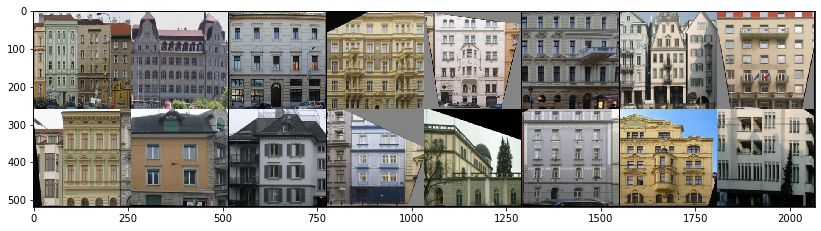

In [51]:
testloader = torch.utils.data.DataLoader(facades_train, batch_size=16, shuffle=True, num_workers=0)
testiter = iter(testloader)
img, masks = testiter.next()

fig, ax = plt.subplots(figsize=(14,14))
ax.imshow(torchvision.utils.make_grid(std*img + mean).detach().numpy().transpose(1, 2, 0), cmap="gray")

try:
    print(dis(img, masks).T)
except NameError:
    pass

## Training

In [52]:
BATCH_SIZE = 1
LR = 0.0002
BETAS = (0.5, 0.999)

gen = Pix2PixGenerator(optim=torch.optim.Adam, lr=LR, betas=BETAS)
dis = Pix2PixDiscriminator(optim=torch.optim.Adam, criterion=torch.nn.BCELoss(), lr=LR, betas=BETAS)

def gen_get_masks(batch_size):
    test_loader = torch.utils.data.DataLoader(facades_test, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
    def get_masks():
        for imgs, masks in itertools.cycle(test_loader):
            yield masks
    return get_masks()

In [55]:
EPOCHS=50
TIME = time.strftime("%Y-%m-%d_%H-%M", time.localtime())

fw_snapshot = gen_save_examples("images/%s" % TIME, gen, cond_gen=gen_get_masks(16),
                                period=25, name_format="{epoch}_{batch}.png",
                                nrow=8, padding=0)
model_snapshot = gen_save_model("models/", gen, dis, BATCH_SIZE, period=100,
                                name_format="facades_%s_{epoch}_{batch}" % TIME)

dataloader = torch.utils.data.DataLoader(facades_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
stats = train(gen, dis, dataloader, epochs=EPOCHS, fw_snapshot=fw_snapshot, model_snapshot=model_snapshot)

D(G(z)): 0.50, generator loss: 50.94, discriminator loss: 0.35


### Loss plot

In [ ]:
show_stats(stats, len(dataloader), EPOCHS, step=1, draw_sma=True, draw_batches=True)

### Save

In [ ]:
save_model("models/", "facades_%s" % TIME, gen, dis, stats, EPOCHS, BATCH_SIZE)

In [ ]:
with imageio.get_writer("images/%s/result_test.gif" % TIME, mode='I', duration=0.1) as writer:
    for i in range(5):
        step = i * 5 +  1
        writer._duration = 0.1 * i + 0.1
        for filename in ["images/%s/%d_%d.png" % (TIME, i, j) for j in range(0, len(dataloader), step)]:
            image = imageio.imread(filename)
            writer.append_data(image)

### Load

In [ ]:
gen = Pix2PixGenerator(optim=torch.optim.Adam)
dis = Pix2PixDiscriminator(optim=torch.optim.Adam, criterion=torch.nn.BCELoss())
EPOCHS, BATCH_SIZE, stats = load_model("models/facades_2020-12-25_23-30_KeyboardInterrupt", gen, dis)

### Generator preview

In [ ]:
test = gen(masks)

fig, ax = plt.subplots(figsize=(14,14))
ax.imshow(torchvision.utils.make_grid(std*test + mean).detach().numpy().transpose(1, 2, 0), cmap="gray")

print(dis(test, masks).T)